### 一.算法介绍
学习向量量化（Learning Vector Quantization,LVQ）是在标签的基础上继续做聚类，打个比方，比如你的数据已经有“好客户”和“坏客户”这两种标签了，但是你想在此基础上继续将“好客户”聚类为“高、中、低”端这三类客户，而对于“坏客户”你想继续聚类为“一般”和“极差”的客户，这便是LVQ要做的事，算法如下   

>输入：样本集$D=\{(x_1,y_1),...,(x_m,y_m)\}$，$q$个原型向量的类别标记$\{t_1,t_2,...,t_q\}$，学习率$\eta\in(0,1)$    
>（1）初始化一组原型向量$\{p_1,p_2,...,p_q\}$   
>（2）重复以下过程，直到停止条件   
>>（2.1）从样本集$D$中随机选取样本$(x_j,y_j)$；   
>>（2.2）计算样本$x_j$与$p_i(1\leq i\leq q)$的距离，$d_{ji}$；   
>>（2.3）找出与$x_j$距离最近的原型向量$p_{i^*}$；   
>>（2.4）如果 $y_j=t_{i^*}$ 则$p'=p_{i^*}+\eta\cdot(x_j-p_{i^*})$，否则$p'=p_{i^*}-\eta\cdot(x_j-p_{i^*})$，并令$p_{i^*}=p'$  
>>（2.5）判断是否满足停止条件，终止循环   
>输出：原型向量$\{p_1,...,p_q\}$

### 二.代码实现

In [13]:
"""
原型聚类LVQ的实现，代码封装在ml_models.cluster
"""

import numpy as np
import copy


class LVQ(object):
    def __init__(self, class_label=None, epochs=100, eta=1e-3, tol=1e-3, dist_method=None):
        """
        :param class_label: 原型向量类别标记
        :param epochs: 最大迭代次数
        :param eta:学习率
        :param tol: 终止条件
        :param dist_method:距离函数，默认欧氏距离
        """
        self.class_label = class_label
        self.epochs = epochs
        self.eta = eta
        self.tol = tol
        self.dist_method = dist_method
        if self.dist_method is None:
            self.dist_method = lambda x, y: np.sqrt(np.sum(np.power(x - y, 2)))
        self.cluster_centers_ = {}  # 记录簇中心坐标

    def fit(self, X, y):
        m = X.shape[0]
        # 随机初始化一组原型向量
        for idx, random_idx in enumerate(np.random.choice(list(range(m)), len(self.class_label), replace=False)):
            self.cluster_centers_[idx] = X[random_idx]
        # 更新
        for _ in range(self.epochs):
            eps = 0
            cluster_centers_old = copy.deepcopy(self.cluster_centers_)
            idxs = list(range(m))
            np.random.shuffle(idxs)
            # 随机选择样本点
            for idx in idxs:
                vec = X[idx]
                yi = y[idx]
                bst_distance = np.infty
                bst_cid = None
                for cid in range(len(self.class_label)):
                    center_vec = self.cluster_centers_[cid]
                    if self.dist_method(vec, center_vec) < bst_distance:
                        bst_distance = self.dist_method(vec, center_vec)
                        bst_cid = cid
                # 更新
                if yi == self.class_label[bst_cid]:
                    self.cluster_centers_[bst_cid] = (1-self.eta)*self.cluster_centers_[bst_cid] + self.eta * vec
                else:
                    self.cluster_centers_[bst_cid] = self.cluster_centers_[bst_cid] - self.eta * (vec - self.cluster_centers_[bst_cid])
            # 判断终止条件
            for key in self.cluster_centers_:
                eps += self.dist_method(cluster_centers_old[key], self.cluster_centers_[key])
            eps /= len(self.cluster_centers_)
            if eps < self.tol:
                break

    def predict(self, X):
        m = X.shape[0]
        rst = []
        for i in range(m):
            vec = X[i]
            best_k = None
            min_dist = np.infty
            for idx in range(len(self.cluster_centers_)):
                dist = self.dist_method(self.cluster_centers_[idx], vec)
                if dist < min_dist:
                    min_dist = dist
                    best_k = idx
            rst.append(best_k)
        return np.asarray(rst)

### 三.测试

In [14]:
from sklearn.datasets.samples_generator import make_blobs
import numpy as np

X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]

# 将0,2类归为0类
y = np.where(y == 2, 0, y)
# 将1,3类归为1类
y = np.where(y == 3, 1, y)

In [15]:
lvq = LVQ(class_label=[0, 0, 1, 1])
lvq.fit(X, y)

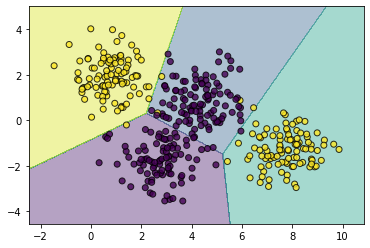

In [16]:
import os 
os.chdir('../')
from ml_models import utils
%matplotlib inline
utils.plot_decision_function(X, y, lvq)
utils.plt.show()

注意，这个算法的监督信息只给了两类，但最后通过聚类得到了4类，也许是我个人认识浅薄：这直接对每个类做个2类的kmeans聚类不就可以了吗~~~，似乎该算法的作用不是很大...

In [17]:
lvq.cluster_centers_

{0: array([ 2.74272756, -1.80402477]),
 1: array([4.31196491, 0.85664122]),
 2: array([ 7.75257292, -1.32958028]),
 3: array([0.76726504, 1.95470454])}